In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

def predict_next_day_close_from_folder(folder_path, max_files=None):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    if max_files is not None:
        csv_files = csv_files[:max_files]

    total_files = len(csv_files)
    print(f"📁 Found {total_files} CSV files in '{folder_path}'\n")

    for idx, file in enumerate(csv_files):
        try:
            file_path = os.path.join(folder_path, file)

            # 🛠 Try reading with header in second row (row index 1)
            raw_df = pd.read_csv(file_path, header=None)
            header_row = raw_df.iloc[0].values
            df = pd.read_csv(file_path, skiprows=1, names=header_row)

            # ✅ Normalize and clean column names
            df.columns = [str(col).lower().strip().replace('*', '') for col in df.columns]

            # ✅ Rename common mismatches
            df.rename(columns={
                'adj close': 'adj_close',
                'close*': 'close'
            }, inplace=True)

            # ✅ Required columns
            required_cols = {'date', 'open', 'high', 'low', 'volume', 'adj_close', 'close'}
            if not required_cols.issubset(df.columns):
                print(f"[{idx+1}/{total_files}] ❌ Skipping {file} - Missing required columns.")
                continue

            # Add stock column if needed
            if 'stock' not in df.columns:
                df['stock'] = file.replace('.csv', '')

            # ✅ Convert and sort by date
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df = df.sort_values('date')
            df.dropna(inplace=True)

            # ✅ Filter out files with too few rows
            if len(df) < 11:
                print(f"[{idx+1}/{total_files}] ❌ Skipping {file} - Not enough rows for training (only {len(df)} rows).")
                continue

            # ✅ Feature engineering
            df['ma5'] = df['close'].rolling(window=5).mean()
            df['ma10'] = df['close'].rolling(window=10).mean()
            df['next_close'] = df['close'].shift(-1)
            df.dropna(inplace=True)

            features = ['open', 'high', 'low', 'volume', 'close', 'ma5', 'ma10', 'adj_close']
            target = 'next_close'

            X = df[features]
            y = df[target]

            X_train = X.iloc[:-1]
            y_train = y.iloc[:-1]
            X_predict = X.iloc[-1:]

            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
            model.fit(X_train, y_train)

            predicted_close = model.predict(X_predict)[0]
            company_name = df['stock'].iloc[-1]
            print(f"[{idx+1}/{total_files}] ✅ {company_name}: Predicted Next Day Close = ₹{predicted_close:.2f}")

        except Exception as e:
            print(f"[{idx+1}/{total_files}] ⚠️ Error processing {file}: {e}")

    print("\n✅ Done with all predictions.")


In [2]:
predict_next_day_close_from_folder('/content/drive/MyDrive/Colab Notebooks/stock market/Data')


Streaming output truncated to the last 5000 lines.
[31/5028] ✅ SIMBHALS.BO: Predicted Next Day Close = ₹6.12
[32/5028] ✅ SIEMENS.BO: Predicted Next Day Close = ₹1124.76
[33/5028] ✅ SINCLAIR.BO: Predicted Next Day Close = ₹178.63
[34/5028] ✅ SMLISUZU.NS: Predicted Next Day Close = ₹384.24
[35/5028] ✅ SIS.BO: Predicted Next Day Close = ₹395.97
[36/5028] ✅ SIMPLXREA.BO: Predicted Next Day Close = ₹34.24
[37/5028] ✅ SML.BO: Predicted Next Day Close = ₹36.20
[38/5028] ✅ SINNAR.BO: Predicted Next Day Close = ₹214.96
[39/5028] ✅ SIMPLEXINF.NS: Predicted Next Day Close = ₹29.43
[40/5028] ✅ SIYSIL.BO: Predicted Next Day Close = ₹135.66
[41/5028] ✅ SICL.BO: Predicted Next Day Close = ₹19.79
[42/5028] ✅ SIL.NS: Predicted Next Day Close = ₹9.90
[43/5028] ✅ SILINV.NS: Predicted Next Day Close = ₹110.98
[44/5028] ✅ SKFL.BO: Predicted Next Day Close = ₹1.74
[45/5028] ✅ SILINFRA.BO: Predicted Next Day Close = ₹8.00
[46/5028] ✅ SIVI.BO: Predicted Next Day Close = ₹59.52
[47/5028] ✅ SINTEX.NS: Predicted

In [12]:
import os
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

def predict_next_day_close_from_folder(folder_path, max_files=None):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    if max_files is not None:
        csv_files = csv_files[:max_files]

    total_files = len(csv_files)
    print(f"📁 Found {total_files} CSV files in '{folder_path}'\n")

    for idx, file in enumerate(csv_files):
        try:
            file_path = os.path.join(folder_path, file)

            # ✅ Skip first 2 rows to reach actual column headers on row 3
            df = pd.read_csv(file_path, skiprows=3)

            # ✅ Rename columns to standard names
            df = df.rename(columns={
                'Date': 'date',
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Vol.': 'volume',
                'Price': 'price',  # or 'Adj Close' if that's the case
                'Close*': 'price'  # backup for Yahoo-style data
            })

            df.columns = [col.lower().strip() for col in df.columns]

            required_cols = {'date', 'open', 'high', 'low', 'volume', 'price'}
            if not required_cols.issubset(df.columns):
                print(f"[{idx+1}/{total_files}] ❌ Skipping {file} - Missing required columns.")
                print("Found columns:", df.columns.tolist())
                continue

            if 'stock' not in df.columns:
                df['stock'] = file.replace('.csv', '')

            df['date'] = pd.to_datetime(df['date'], format='%d %b %Y', errors='coerce')
            df = df.sort_values('date', ascending=True)   # ✅ train oldest → newest
            df.dropna(inplace=True)
            print(df.head())

            df['ma5'] = df['price'].rolling(window=5).mean()
            df['ma10'] = df['price'].rolling(window=10).mean()
            df['next_close'] = df['price'].shift(-1)
            df.dropna(inplace=True)

            features = ['open', 'high', 'low', 'volume', 'price', 'ma5', 'ma10']
            target = 'next_close'

            X = df[features]
            y = df[target]

            X_train = X.iloc[:-1]
            y_train = y.iloc[:-1]
            X_predict = X.iloc[-1:]

            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
            model.fit(X_train, y_train)
            predicted_close = model.predict(X_predict)[0]
            company_name = df['stock'].iloc[-1]

            print(f"[{idx+1}/{total_files}] ✅ {company_name}: Predicted Next Day Close = ₹{predicted_close:.2f}")

        except Exception as e:
            print(f"[{idx+1}/{total_files}] ⚠️ Error processing {file}: {e}")

    print("\n✅ Done with all predictions.")

    import matplotlib.pyplot as plt

    # Example: Predict last 10 values
    y_true = y[-10:]
    y_pred = model.predict(X[-10:])

    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values, label='Actual Close', marker='o')
    plt.plot(y_pred, label='Predicted Close', marker='x')
    plt.title(f'{company_name} - Last 10 Days: Actual vs Predicted')
    plt.xlabel('Days')
    plt.ylabel('Close Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.show()


this is i am doing on 13-06-2025 to predict the monday closing price of HDFC bank

📁 Found 1 CSV files in '/content/drive/MyDrive/Colab Notebooks/HDFC BANK'

           date    price     open     high      low    volume change(%)  \
1241 2020-06-17   979.25   989.00   998.90   973.25  18479504    -1.13%   
1240 2020-06-18  1019.95   980.00  1024.90   972.00  20435469     4.16%   
1239 2020-06-19  1033.35  1017.95  1043.00  1012.15  23939324     1.31%   
1238 2020-06-22  1028.75  1039.45  1045.95  1023.80  14847321    -0.45%   
1237 2020-06-23  1042.30  1039.00  1045.00  1016.55  14415640     1.32%   

         stock  
1241  download  
1240  download  
1239  download  
1238  download  
1237  download  
[1/1] ✅ download: Predicted Next Day Close = ₹1944.47

✅ Done with all predictions.


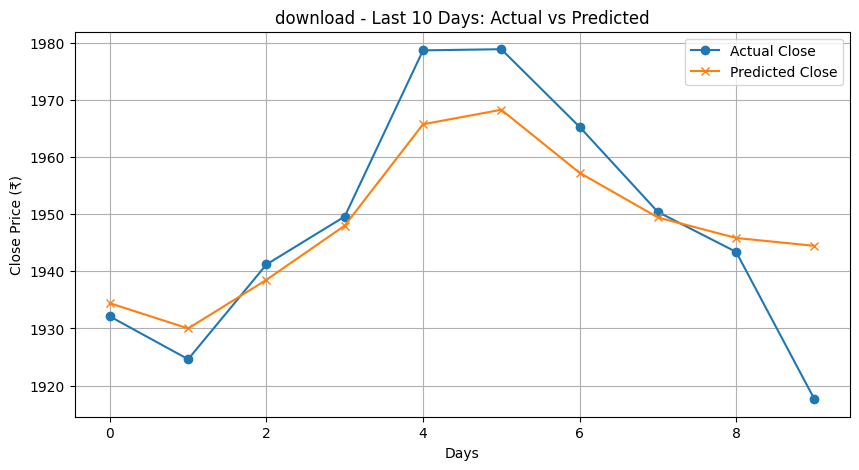

In [13]:
predict_next_day_close_from_folder("/content/drive/MyDrive/Colab Notebooks/HDFC BANK")

So the closing price of HDFC bank is 1935.4